In [75]:
import blackjackSim as bjs
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import uuid
import warnings
import random
import seaborn as sns
import tensorflow as tf

In [2]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, Dropout

In [3]:
#retrieve full data
full_data = pd.read_csv("blackjack_data.csv")

In [4]:
def sample_groupby_games(df, frac, return_complement = False):
    groupby = df.groupby("game number")
    main_df = pd.DataFrame()
    comp_df = pd.DataFrame() #Everything from original df not in main_df
    for i in groupby:
        if random.random() < frac:
            a = i[1]
            main_df = pd.concat((main_df, a))
        else:
            if return_complement == True:
                a = i[1]
                comp_df = pd.concat((comp_df, a))
    if return_complement == False:
        return main_df
    else:
        return main_df, comp_df

In [20]:
train_data, test_data = sample_groupby_games(full_data, 0.75, return_complement=True)

train_features = train_data[['points', 'aces', 'dealer card', 'round']]
test_features = test_data[['points', 'aces', 'dealer card', 'round']]

train_labels = train_data["label"]
test_labels = test_data["label"]

In [21]:
model = tf.keras.models.Sequential()
model.add(Dense(16))
model.add(Dense(128))
model.add(Dense(32))
model.add(Dense(8))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='sgd')
model.fit(train_data[['points', 'aces', 'dealer card', 'round']],
          train_data['label'], epochs=200, batch_size=256, verbose=1)

Epoch 1/200
186/186 [==============================] - 1s 4ms/step - loss: 0.9750
Epoch 2/200
186/186 [==============================] - 0s 2ms/step - loss: 0.6641
Epoch 3/200
186/186 [==============================] - 0s 2ms/step - loss: 0.6625
Epoch 4/200
186/186 [==============================] - 0s 2ms/step - loss: 0.6572
Epoch 5/200
186/186 [==============================] - 0s 3ms/step - loss: 0.6548
Epoch 6/200
186/186 [==============================] - 0s 2ms/step - loss: 0.6548
Epoch 7/200
186/186 [==============================] - 0s 2ms/step - loss: 0.6594
Epoch 8/200
186/186 [==============================] - 0s 2ms/step - loss: 0.6470
Epoch 9/200
186/186 [==============================] - 0s 3ms/step - loss: 0.6476
Epoch 10/200
186/186 [==============================] - 0s 2ms/step - loss: 0.6514
Epoch 11/200
186/186 [==============================] - 0s 2ms/step - loss: 0.6461
Epoch 12/200
186/186 [==============================] - 0s 2ms/step - loss: 0.6465
Epoch 13/200


186/186 [==============================] - 1s 3ms/step - loss: 0.6355
Epoch 100/200
186/186 [==============================] - 0s 3ms/step - loss: 0.6354
Epoch 101/200
186/186 [==============================] - 0s 2ms/step - loss: 0.6329
Epoch 102/200
186/186 [==============================] - 0s 2ms/step - loss: 0.6373
Epoch 103/200
186/186 [==============================] - 0s 2ms/step - loss: 0.6359
Epoch 104/200
186/186 [==============================] - 0s 2ms/step - loss: 0.6364
Epoch 105/200
186/186 [==============================] - 0s 2ms/step - loss: 0.6347
Epoch 106/200
186/186 [==============================] - 0s 2ms/step - loss: 0.6371
Epoch 107/200
186/186 [==============================] - 0s 2ms/step - loss: 0.6360
Epoch 108/200
186/186 [==============================] - 0s 2ms/step - loss: 0.6349
Epoch 109/200
186/186 [==============================] - 0s 2ms/step - loss: 0.6356
Epoch 110/200
186/186 [==============================] - 0s 3ms/step - loss: 0.6351
Epoch 

186/186 [==============================] - 1s 4ms/step - loss: 0.6358
Epoch 197/200
186/186 [==============================] - 1s 4ms/step - loss: 0.6359
Epoch 198/200
186/186 [==============================] - 1s 4ms/step - loss: 0.6353
Epoch 199/200
186/186 [==============================] - 1s 4ms/step - loss: 0.6358
Epoch 200/200
186/186 [==============================] - 1s 4ms/step - loss: 0.6349


In [22]:
hitbutton = widgets.Button(description = "Hit",
                          disabled = False, 
                          button_style = '',
                          tooltip = "Hit",
                          icon = "hand-fist")

def hbc(b):
    clear_output()
    display(hitbutton)
    display(staybutton)
    display(predictbutton)
    game.hit()
    
hitbutton.on_click(hbc) #runs hbc(hitbutton) when you click the hit button

staybutton = widgets.Button(description = "Stand",
                          disabled = False, 
                          button_style = '',
                          tooltip = "Stand",
                          icon = "hand")

def sbc(b):
    clear_output()
    display(hitbutton)
    display(staybutton)
    display(predictbutton)
    game.stay()
    
staybutton.on_click(sbc) #runs sbc(staybutton) when you click the stay button

predictbutton = widgets.Button(description = "Predict",
                          disabled = False, 
                          button_style = '',
                          tooltip = "What should I do?",
                          icon = "hand")

def pbc(b):
    feat = game.get_features()
    pred = model.predict(feat)[0,0]
    if pred > 0.5:
        print("You should hit")
    else:
        print("You should stay")
        
predictbutton.on_click(pbc)

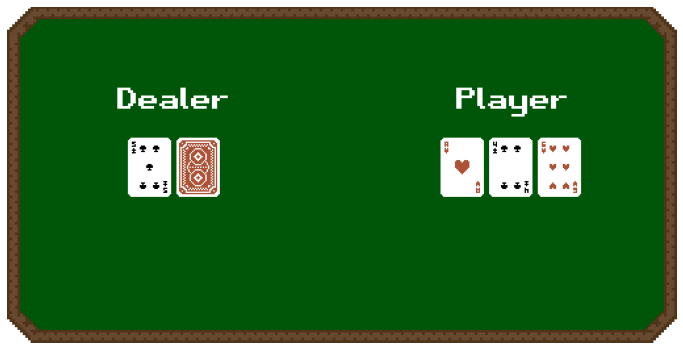

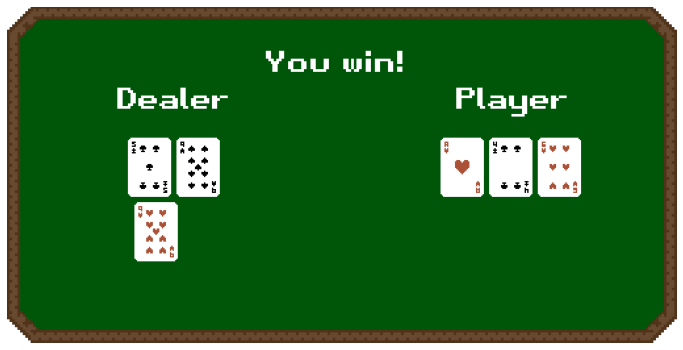

In [46]:
game = bjs.Blackjack(draw = True)

display(hitbutton)
display(staybutton)
display(predictbutton)

# Data generation

In [15]:
hit_threshold = 0.7 #if random.random() is above this number, hit
n_wins = 0 #number of wins
iterations = 100000 #number of games to simulate
#Simulation output
win = [] # Win(1), Loss(0)
aces = [] # Number of aces in player's hand
points = [] # Number of points the player's hand is worth
dealer_card = [] # Value/rank of dealer's face-up card

hit = [] # Whether the player did hit or stay
round_ = [] # Which round of the game it is, where the first round of the game is 1
game_number = [] # Number assigned to that game

current_game = 1 # Number assigned to that game
instant_gameovers = 0 # How many times the game is won just from the dealing of cards, e.g. player or dealer receives 21
for i in range(iterations):
    game = bjs.Blackjack() #initialize game
    current_round = 0
    if game.is_active == False: # Only activated in case of an instant game over
        instant_gameovers += 1
        current_game += 1
        continue
    else:
        while game.is_active == True: # While the game still hasn't ended:
            
            #Add features to lists
            points.append(game.point())
            dealer_card.append(game.dealer[0])
            aces.append(game.aces())
            round_.append(current_round)
            
            if game.point() < 11: # Always hit if you have 10 points or less, it's impossible to lose
                game.hit()
                hit.append(1)
                current_round += 1
            elif random.random() > hit_threshold: # Hit if above threshold
                game.hit()
                hit.append(1)
                current_round += 1
            else: # Stay if below threshold
                game.stay()
                hit.append(0)
                current_round += 1

            

        for j in range(current_round): #assigning win and game labels to all turns
            game_number.append(current_game)
            win.append(game.player_win)

        if game.player_win == True:
            n_wins += 1

        current_game += 1

In [16]:
label = [] #list of labels. If 1, then either a hit resulted in a win, or a stay resulted in a loss. If 0, then either a
           #stay resulted in a win, or a hit resulted in a loss. This is a big assumption, and how accurate it is will
           #determine how well the model can play blackjack
for i in range(len(win)):
    if win[i] == 0:
        if hit[i] == 0:
            label.append(1) #should've hit
        elif hit[i] == 1:
            label.append(0) #should've stayed
    elif win[i] == 1:
        label.append(hit[i]) #did the right thing, so just add that

In [17]:
import pandas as pd
data = pd.DataFrame()
data["label"] = label
data["win"] = win
data["points"] = points
data["aces"] = aces


data["dealer card"] = np.array(dealer_card)[:,1]
data["dealer card"] = data["dealer card"].replace({"Jack":10, "Queen":10, "King":10, "Ace":11}) #Change names to numbers
data["dealer card"] = pd.to_numeric(data["dealer card"]) #Change series dtype from string to a numeric 
data["round"] = round_
data["game number"] = game_number

In [18]:
win_data = data[ data["win"] == True]
big_loss_data = data[ data["win"] == False]

test_rounds = len(win_data) 
loss_proportion = test_rounds/len(big_loss_data) # this portion test size for loss data

#Split winning and losing data

loss_proportion

0.3571120101827439

In [19]:
loss_data = sample_groupby_games(big_loss_data, loss_proportion)

#Generate full data
full_data = pd.concat((win_data, loss_data))

In [47]:
# Save full data
full_data.to_csv("blackjack_data.csv")

# Plotting

In [77]:
#Generate heatmap for likelihood of hitting given player, dealer cards
#Aces and round number are assumed to be

model_output = np.zeros((19,10)) #Output shape
for i in range(2,12): #through dealer card values
    display_data = pd.DataFrame()

    display_data["points"] = range(2,21) #possible player hand values
    display_data["aces"] = np.ones(19)
    display_data["round"] = np.zeros(19)
    display_data["dealer card"] = np.array([i]*19) #all same dealer
    
    pred_ary = model.predict(display_data)
    
    for j in range(len(pred_ary)):
        model_output[j, i-2] = pred_ary[j][0]


Text(0.5, 33.0, "Points of dealer's face-up card")

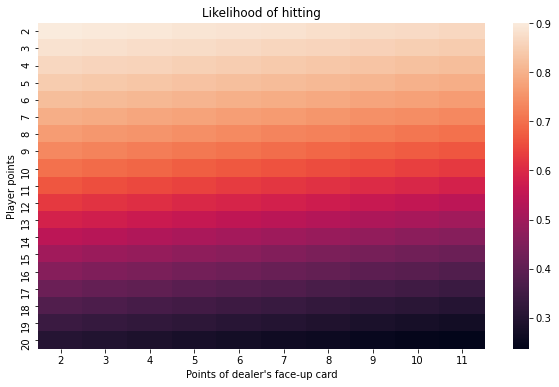

In [80]:
plt.figure(figsize = (10,6))
sns.heatmap(model_output, xticklabels = range(2,12), yticklabels = range(2,21))
plt.title("Likelihood of hitting")
plt.ylabel("Player points")
plt.xlabel("Points of dealer's face-up card")

Text(0.5, 1.0, 'Win Prob vs. Dealer Card')

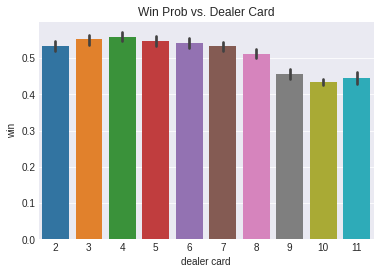

In [83]:
#plot probability of win vs. dealer card
sns.barplot(x = 'dealer card', y = 'win', data = full_data)
#add a title
plt.title('Win Prob vs. Dealer Card')


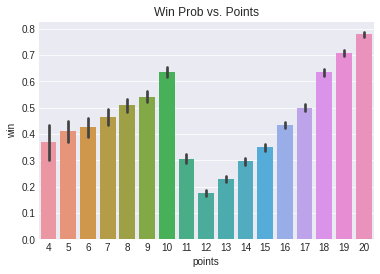

In [84]:
#barplot of win vs. points
sns.barplot(x = 'points', y = 'win', data = full_data)
#add a title
plt.title('Win Prob vs. Points')
#change the theme
plt.style.use('seaborn-darkgrid')

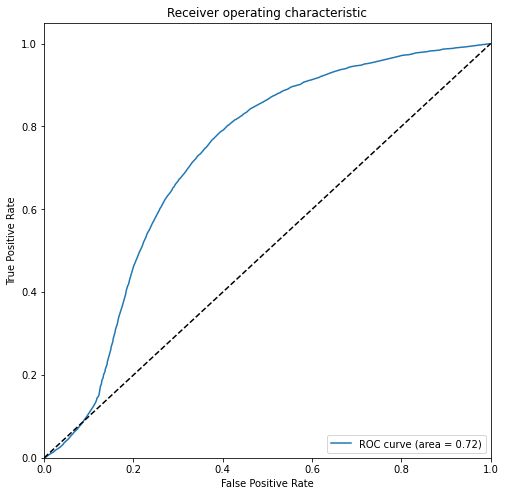

In [28]:
#plot ROCCurve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(full_data['label'], model.predict(full_data[['points', 'aces', 'dealer card', 'round']]))
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(8,8))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()